In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models,transforms
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!nvidia-smi

Mon May 29 14:41:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!rm -rf khokhloma2gzhel/
!rm -rf test*
!unzip -q /content/gdrive/My\ Drive/khokhloma2gzhel.zip

In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import mse_loss, l1_loss
from torchvision import transforms

In [ ]:
class dataset (Dataset):
    def __init__(self, files,mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        self.len_ = len(self.files)
        self.mode = mode
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        #аугментация, применяется только к train
        if self.mode=='train':
            t=transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomResizedCrop(256,scale=(0.8,1)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
            x=t(x)
        else:
            t=transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
            x=t(x)            
        return x

In [ ]:
from pathlib import Path
trA_dir=Path('khokhloma2gzhel/trainA')
trB_dir=Path('khokhloma2gzhel/trainB')
tsA_dir=Path('khokhloma2gzhel/testA')
tsB_dir=Path('khokhloma2gzhel/testB')

In [ ]:
import os
os.listdir('khokhloma2gzhel/')

['testA', 'trainB', 'trainA', 'testB']

In [ ]:
train_A = sorted(list(trA_dir.rglob('*.jpg')))
train_B = sorted(list(trB_dir.rglob('*.jpg')))
test_A = sorted(list(tsA_dir.rglob('*.jpg')))
test_B = sorted(list(tsB_dir.rglob('*.jpg')))
trA_dataset=dataset(train_A,mode='train')
trB_dataset=dataset(train_B,mode='train')
tsA_dataset=dataset(test_A,mode='test')
tsB_dataset=dataset(test_B,mode='test') 
batch_size = 5
data_tr_A = DataLoader(trA_dataset,
                      batch_size=batch_size, shuffle=True)
data_tr_B = DataLoader(trB_dataset,
                      batch_size=batch_size, shuffle=True)
data_ts_A = DataLoader(tsA_dataset,
                      batch_size=batch_size, shuffle=False)
data_ts_B = DataLoader(tsB_dataset,
                      batch_size=batch_size, shuffle=False)

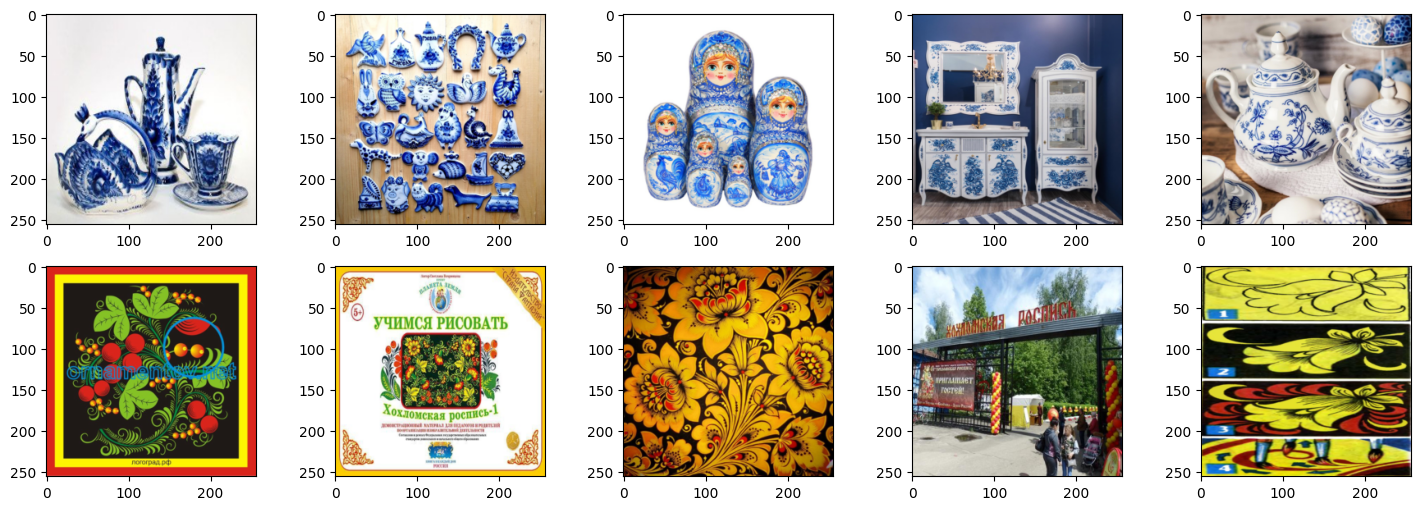

In [ ]:

import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.figure(figsize=(18, 6))
ex=next(iter(data_ts_A))
for i in range (0,5):    
    plt.subplot(2, 5, i+1)
    plt.imshow(np.rollaxis((ex[i].numpy()+1)/2,0,3))
ex=next(iter(data_ts_B))
for i in range(0,5):
    plt.subplot(2, 5, i+6)
    plt.imshow(np.rollaxis((ex[i].numpy()+1)/2,0,3))
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self,in_dim,out_dim):
        super().__init__()
        self.conv1=nn.Sequential(nn.Conv2d(in_dim,out_dim,kernel_size=3,stride=1,padding=1,padding_mode='reflect'),
                                 nn.InstanceNorm2d(out_dim))
        self.conv2=nn.Sequential(nn.Conv2d(out_dim,out_dim,kernel_size=3,stride=1,padding=1,padding_mode='reflect'),
                                 nn.InstanceNorm2d(out_dim))
    def forward (self,x):
        res=F.relu(self.conv1(x))
        res=self.conv2(res)
        return res+x

class Generator (nn.Module):
    def __init__(self):
        super().__init__()
        #encoder
        self.enc_conv1=nn.Sequential(nn.Conv2d(in_channels=3,out_channels=64,kernel_size=7,stride=1,padding=3,padding_mode='reflect'),
                                     nn.InstanceNorm2d(64))
        self.enc_conv2=nn.Sequential(nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1,padding_mode='reflect'),
                                     nn.InstanceNorm2d(128))
        self.enc_conv3=nn.Sequential(nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=2,padding=1,padding_mode='reflect'),
                                     nn.InstanceNorm2d(256))
        #bottleneck
        self.bn=nn.Sequential(ResidualBlock(256,256),ResidualBlock(256,256),
                               ResidualBlock(256,256),ResidualBlock(256,256),
                              ResidualBlock(256,256))
        #decoder
        self.dec_conv1=nn.Sequential(nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=3,stride=2,padding=1),
                                     nn.ReflectionPad2d((1,0,1,0)),
                                     nn.InstanceNorm2d(128))
        self.dec_conv2=nn.Sequential(nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=3,stride=2,padding=1),
                                     nn.ReflectionPad2d((1,0,1,0)),
                                     nn.InstanceNorm2d(64))
        self.dec_conv3=nn.Sequential(nn.ReflectionPad2d(3),nn.Conv2d(in_channels=64,out_channels=3,kernel_size=7,stride=1))

    def forward(self,x):
        e1=F.relu(self.enc_conv1(x))
        e2=F.relu(self.enc_conv2(e1))
        e3=F.relu(self.enc_conv3(e2))
        bn=self.bn(e3)
        d1=F.relu(self.dec_conv1(bn))
        d2=F.relu(self.dec_conv2(d1))
        d3=torch.tanh(self.dec_conv3(d2))
        return d3


class Discriminator (nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Sequential(nn.Conv2d(in_channels=3,out_channels=64,kernel_size=4,stride=2,padding=1,padding_mode='reflect'),
                                     nn.InstanceNorm2d(64))
        self.conv2=nn.Sequential(nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1,padding_mode='reflect'),
                                     nn.InstanceNorm2d(128))
        self.conv3=nn.Sequential(nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1,padding_mode='reflect'),
                                     nn.InstanceNorm2d(256))
        self.conv4=nn.Sequential(nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,padding=1,padding_mode='reflect'),
                                     nn.InstanceNorm2d(512))
        self.out=nn.Sequential(nn.Conv2d(512,1,4,1),nn.ReflectionPad2d((1,2,1,2)))

        self.avg=nn.AdaptiveAvgPool2d(1)

    def forward(self,x):
        c1=F.leaky_relu(self.conv1(x),negative_slope=0.2, inplace=True)
        c2=F.leaky_relu(self.conv2(c1),negative_slope=0.2, inplace=True)
        c3=F.leaky_relu(self.conv3(c2),negative_slope=0.2, inplace=True)
        c4=F.leaky_relu(self.conv4(c3),negative_slope=0.2, inplace=True)
        res=self.avg(self.out(c4))
        return res
         


        




In [ ]:
def train(gA,gB,dA,dB,tr_A,tr_B,epochs,test_A,test_B):
    history=[]
    opt_gA=optim.Adam(gA.parameters(),lr=2e-5,betas=(0.5,0.99))
    opt_gB=optim.Adam(gB.parameters(),lr=2e-5,betas=(0.5,0.99))
    opt_dA=optim.Adam(dA.parameters(),lr=2e-5,betas=(0.5,0.99))
    opt_dB=optim.Adam(dB.parameters(),lr=2e-5,betas=(0.5,0.99))
    a_test=next(iter(test_A)).to(device)
    b_test=next(iter(test_B)).to(device)
    lamb=10
    len_min=396
    
    for epoch in range(0,epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_lossG =0
        avg_lossDa=0
        avg_lossDb=0
        for a_real, b_real in  zip(tr_A,tr_B):
            gA.train()
            gB.train()
            dA.train(False)
            dB.train(False)
            for param in gA.parameters():
                param.requires_grad = True
            for param in gB.parameters():
                param.requires_grad = True
            a_real=a_real.to(device)
            b_real=b_real.to(device) 
            b_fake=(gB(a_real))
            a_fake=(gA(b_real))
            a_2=(gA(b_fake))
            b_2=(gB(a_fake))
            a_id=(gA(a_real))
            b_id=(gB(b_real))
            # gen losses
            a_f=dA(a_fake)
            b_f=dB(b_fake)
            r_label = (torch.ones(a_f.size())).to(device)
            a_gen_loss = mse_loss(a_f, r_label)
            b_gen_loss = mse_loss(b_f, r_label)
            a_rec_loss= l1_loss(a_2,a_real)
            b_rec_loss=l1_loss(b_2,b_real)
            a_id_loss=l1_loss(a_id,a_real)
            b_id_loss=l1_loss(b_id,b_real)
            loss=a_gen_loss+lamb*a_rec_loss+b_gen_loss+lamb*b_rec_loss+0.5*lamb*a_id_loss+0.5*lamb*b_id_loss
            for param in dA.parameters():
                param.requires_grad = False
            for param in dB.parameters():
                param.requires_grad = False
            gA.zero_grad()
            gB.zero_grad()                             
            loss.backward()
            opt_gA.step()
            opt_gB.step()
            gA.train(False)
            gB.train(False)
            dA.train()
            dB.train()
            for param in dA.parameters():
                param.requires_grad = True
            for param in dB.parameters():
                param.requires_grad = True
            b_fake = b_fake.cpu().detach().numpy()
            b_fake = torch.tensor(b_fake).to(device)
            a_fake = a_fake.cpu().detach().numpy()
            a_fake = torch.tensor(a_fake).to(device)            
            d_a_r=dA(a_real)
            d_a_f=dA(a_fake)
            d_b_r=dB(b_real)
            d_b_f=dB(b_fake) 
            r_label = (torch.ones(a_f.size())).to(device)
            f_label = (torch.zeros(a_f.size())).to(device)
            a_r_loss=mse_loss(d_a_r,r_label)
            a_f_loss=mse_loss(d_a_f,f_label)
            b_r_loss=l1_loss(d_b_r,r_label)
            b_f_loss=l1_loss(d_b_f,f_label)
            a_total=0.5*(a_r_loss+a_f_loss)
            b_total=0.5*(b_r_loss+b_f_loss)
            for param in gA.parameters():
                param.requires_grad = False
            for param in gB.parameters():
                param.requires_grad = False
            dA.zero_grad()
            dB.zero_grad()                    
            a_total.backward()
            b_total.backward()
            opt_dA.step()
            opt_dB.step()
            avg_lossG+=loss/len_min
            avg_lossDa+=a_total/len_min
            avg_lossDb+=b_total/len_min
        gA.eval()
        gB.eval()  
        with torch.no_grad():
            b_fake=(gB(a_test))
            a_fake=(gA(b_test))
            a_2=(gA(b_fake))
            b_2=(gB(a_fake))
        clear_output(wait=True)
        plt.figure(figsize=(18,15))
        for k in range (0,5):
            a1=(a_test.cpu().detach()[k]+1)/2
            a2=(a_fake.cpu().detach()[k]+1)/2
            a3=(a_2.cpu().detach()[k]+1)/2
            b1=(b_test.cpu().detach()[k]+1)/2
            b2=(b_fake.cpu().detach()[k]+1)/2
            b3=(b_2.cpu().detach()[k]+1)/2
            plt.subplot(5, 6, k*6+1)
            plt.imshow(np.rollaxis(a1.numpy(), 0, 3))
            plt.subplot(5, 6, k*6+2)
            plt.imshow(np.rollaxis(b2.numpy(), 0, 3))
            plt.subplot(5, 6, k*6+3)
            plt.imshow(np.rollaxis(a3.numpy(), 0, 3))        
            plt.subplot(5, 6, k*6+4)
            plt.imshow(np.rollaxis(b1.numpy(), 0, 3))
            plt.subplot(5,6, k*6+5)
            plt.imshow(np.rollaxis(a2.numpy(), 0, 3))
            plt.subplot(5, 6, k*6+6)
            plt.imshow(np.rollaxis(b3.numpy(), 0, 3))
            plt.suptitle('%d / %d - gen_loss:  %f dA_loss: %f dB_loss: %f '% (epoch+1, epochs, avg_lossG,avg_lossDa,avg_lossDb))
        plt.show()
        history.append((epoch,avg_lossG.item(),avg_lossDa.item(),avg_lossDb.item()))
        torch.save(gA.state_dict(), "/content/gdrive/My Drive/gA_weights_htg.pth")
        torch.save(gB.state_dict(), "/content/gdrive/My Drive/gB_weights_htg.pth")
        torch.save(dA.state_dict(), "/content/gdrive/My Drive/dA_weights_htg.pth")
        torch.save(dB.state_dict(), "/content/gdrive/My Drive/dB_weights_htg.pth")
        with open ('/content/gdrive/My Drive/log_GAN_NEW_htg.csv',mode='a') as f:
            f.write('%d,%f,%f,%f \n'% (epoch+1, avg_lossG,avg_lossDa,avg_lossDb))
    return history

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic=True

genA=Generator().to(device)
genB=Generator().to(device)
disA=Discriminator().to(device)
disB=Discriminator().to(device)


In [ ]:
genA.load_state_dict(torch.load("/content/gdrive/My Drive/gA_weights_htg.pth"))
genB.load_state_dict(torch.load("/content/gdrive/My Drive/gB_weights_htg.pth"))
disA.load_state_dict(torch.load("/content/gdrive/My Drive/dA_weights_htg.pth"))
disB.load_state_dict(torch.load("/content/gdrive/My Drive/dB_weights_htg.pth"))

FileNotFoundError: ignored

In [ ]:
history=train(genA,genB,disA,disB,data_tr_A,data_tr_B,30,data_ts_A,data_ts_B)


* Epoch 1/30


In [ ]:
def predict(gen,test):
    gen.eval()
    i=0
    for pic in test:
        plt.figure(figsize=(18,5))
        pic=pic.to(device)
        res=gen(pic)
        for k in range (0,5):   
            plt.subplot(2, 5, k+1)
            inp=(pic.cpu().detach()[k]+1)/2
            plt.imshow(np.rollaxis(inp.numpy(),0,3))
        for k in range (0,5):   
            plt.subplot(2, 5, k+6)
            inp=(res.cpu().detach()[k]+1)/2
            plt.imshow(np.rollaxis(inp.numpy(),0,3))
        plt.savefig('/content/gdrive/My Drive/g2h/h2gz'+str(i)+'.png')
        i+=1
        print(i)

predict(genA,data_ts_B)

In [ ]:
a